# compare saved models on test data

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
images_test_dir = '../images_test/'
# to build PATH to save the best model
model_dir = 'myModels/best/'
# where to save plots from evaluation on the test set
test_plots_dir = 'test_plots/'
# eventually do evaluation for all models in model_dir
# for now load a single model and get it to do predictions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("torch.cuda.is_available(): ", torch.cuda.is_available())

torch.cuda.is_available():  True


# load model(s)

## load one model
run one of the cells. Each cell gets a PATH to a saved model in a *.pt-file and defines the model (the same modell class or type as the saved model).

In [3]:
from myModels import myModels as mm # mm = myModels

PATH = model_dir+'MyNeuralNetwork3_acc9300.pt'
model = mm.MyNeuralNetwork3()
model.load_state_dict(torch.load(PATH))

model.eval() # we want to do predictions, not training
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

MyNeuralNetwork3(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3844, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)

In [4]:
from torchvision import models
import torch.nn as nn

PATH = model_dir+'resnet18_pretrained.pt'
model = models.resnet18(pretrained=True)
# adapt model as in training , repeat the transfer part
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
# now model fits the model we saved the parameters for

model.load_state_dict(torch.load(PATH))

model.eval() # we want to do predictions, not training
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# test data set

In [5]:
import test
import pandas as pd
from torchvision import transforms, utils

print('images in images test dir '+ images_test_dir +' : ' )
!ls $images_test_dir | wc -l 

# imgH, imgW = model.get_img_shape()
# for resNet
imgH = imgW = 224

transform = transforms.Compose([
    transforms.Resize((imgH,imgW)), # imgH, imgW as required for model
    transforms.ToTensor()
])

df = pd.read_csv('../meta/labels2k_A_test.csv', index_col=0) 
df.index=range(df.shape[0])
setup = df[['Gender','Age','Race','newFilename']].copy()

testset = test.TestSet(images_dir=images_test_dir , setup=setup, transform=transform)
batch_size=5 # this should be automated # this can be set to any value! 1,5,10, 100 (=size of test set)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

images in images test dir ../images_test/ : 
100


In [6]:
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

def run_test_short(data_loader, model):
    
    # running statistic ends with _r
    error_eg_r = np.zeros((7,2))
    tots_r = np.zeros((7,2))
    
    error_rel = np.zeros((3,2))

    # do not compute gradients
    with torch.no_grad():
        for inputs, labels in data_loader:
            
            # batch statistic end with _b
            error_eg_b = np.zeros((7,2))
            tots_b = np.zeros((7,2))
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.tolist()
        
            labels_e = labels['ethnicity'].tolist()
            labels_f = labels['file']
            labels_g = labels['gender'].tolist()
              
            diff = [i-j for (i,j) in zip(labels_g,preds)] # values -1,0,1
            for d , e , g  in zip(diff, labels_e, labels_g):
                error_eg_b[e,g] += d*d # error : d==1,-1 then d*d = 1, so we add 1 to the error matrix at [e,g]
                tots_b[e,g]+=1
                
            # running statistic, ends with _r
            error_eg_r += error_eg_b
            tots_r += tots_b

    error_eg_r[3,:] += error_eg_r[0,:]+error_eg_r[4:7,:].sum(axis=0)
    error_eg_r = error_eg_r[1:4]
    
    tots_r[3,:] += tots_r[0,:]+tots_r[4:7,:].sum(axis=0)
    tots_r = tots_r[1:4]
    
    return error_eg_r , tots_r 

def matrix_division (error, tots):
    '''given 2 matrices of same shape, divide one by the other, element wise'''
    assert error.shape == tots.shape, 'matrices have to be of the same shape.'
    
    error_rel = np.zeros(error.shape)
    
    for e in range(error.shape[0]):
        for g in range(error.shape[1]):
            if tots[e,g]==0:
                error_rel[e,g]=None
            else:
                error_rel[e,g] = error[e,g] / tots[e,g]
    return error_rel

The next cell does the work and produces the output.

in TestSet.len returning : 100
accuracy :  0.95
highest error rate in ethnicities 1,2 : 0.16666666666666666


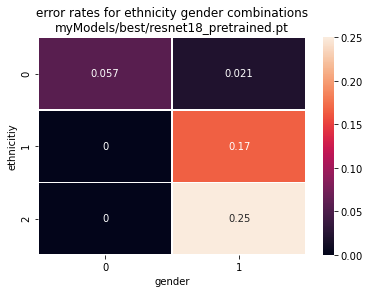

In [7]:

err, tot = run_test_short(test_loader, model)
err_rel = matrix_division(err,tot)
#print(err_rel)
sns.heatmap(err_rel, linewidth=0.5, annot=True)
plt.title('error rates for ethnicity gender combinations\n'+PATH)
plt.xlabel('gender')
plt.ylabel('ethnicitiy')
try:
    plt.savefig(test_plots_dir+model.get_model_name()+'_error.png')
except:
    plt.savefig(test_plots_dir+'resnet_error.png')
#plt.show()
# put these numbers in an np array or pandas df
print('accuracy : ' , (tot.sum() - err.sum()) / tot.sum() )
print('highest error rate in ethnicities 1,2 :' , max(np.ravel(err_rel[0:2,:])))

For this model MyNeuralNetwork3 the validation accuracy was .93, on the test set we gor .87
So the model got lucky on the dev set but not on the test set. too bad ;-)

In [ ]:
def run_test_0():
    # running statistics end with _r
    cfm_r = np.zeros((2,2))
    recall_by_e_r = np.zeros((2,7,2))
    f1_r = [] 

    # do not compute gradients
    with torch.no_grad():
        for inputs, labels in test_loader:
        
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.tolist()
        
            labels_e = labels['ethnicity'].tolist()
            labels_f = labels['file']
            labels_g = labels['gender'].tolist()
            labels_a = labels['age'].tolist()
        
            # batch statistics, end with _b
            cfm_b = confusion_matrix(labels_g, preds, labels=[0,1])

            recall_by_e_b = np.zeros((2,7,2), dtype=np.int8)
            diff = [i-j for (i,j) in zip(labels_g,preds)] # values -1,0,1
            for d , e , g  in zip(diff, labels_e, labels_g):
                recall_by_e_b[d, e, g] += 1 
                
            # running statistics, end with _r
            cfm_r += cfm_b
            recall_by_e_r += recall_by_e_b

    tn, fp, fn, tp = cfm_r.ravel()
    f1_m = 2*tp/(2*tp+fp+fn) # male as positive class
    f1_f = 2*tn/(2*tn+fp+fn) # female as positive class (or f1 for the negaive class)

    #print('confusion matrix : \n' , cfm_r )
    #print('f1 score for the male/1 class: ' , round(f1_m,4) , '\nf1 for female/0 class : ' , round(f1_f,4) )
    df2 = pd.DataFrame(np.concatenate([recall_by_e_r[0,:,:],recall_by_e_r[1,:,:]], axis=1))
    print('gender recall grouped by ethnicity:\n' , df2)
    
    return df2

In [93]:
df2 = run_test_0()
a = df2.loc[[1,2,3]].to_numpy() # take 3 rows for ethnicities 1=white, 2=black, 3,4=...asian , 5=latinxplt.imshow(a, cmap='hot', interpolation='nearest')
a[2,:]= a[2,:]+df2.loc[[0,4,5,6]].sum(axis=0) # add the other rows to the asian row , row 0 was for undecided ethnicity and is empty in the test set
a

in TestSet.len returning : 100
gender recall grouped by ethnicity:
       0     1    2    3
0   0.0   0.0  0.0  0.0
1  32.0  40.0  3.0  7.0
2   3.0   6.0  1.0  0.0
3   2.0   1.0  0.0  0.0
4   0.0   0.0  0.0  0.0
5   2.0   1.0  0.0  1.0
6   0.0   0.0  0.0  1.0


array([[32., 40.,  3.,  7.],
       [ 3.,  6.,  1.,  0.],
       [ 4.,  2.,  0.,  2.]])

In [32]:
# recall = tp/(tp+fn) for the positive class female (=0) or male (=1)
# rows in a : [t*, t* , f* ,f*] correct classification (d=0) in the first 2 columns, misclassifications (d=1,-1) in the 3rd, 4th column
# consider 0/female the positive class then the rows are [tp,tn,fn,fp] , because labeled females are gender 0 in columns 1 and 3 (0based column indexes: 0,2)
# consider 1/male the positive class then the rows are [tn,tp,fp,fn]

def tpr (b,g): # g in {0,1}, g+2 in {2,3}, so g,g+2 =0,2 or =1,3 the indices for recall in [t*,t*,f*,f*] depending on gender g
    if b[g]+b[g+2]: # true when sum positive
        return b[g]/(b[g]+b[g+2])
    else:
        return None
    
def re_call (a):
    b = np.zeros((3,2))
    for e in range(3):
        for g in range(2):
            b[e,g]= tpr(a[e,:],g)
    return b # np.round(100*b,1)

In [21]:
import seaborn as sns
#import matplotlib.pylab as plt

def heatmap_recall(b): 
    ax = sns.heatmap(b, linewidth=0.5, annot=True)
    plt.title('recall of gender grouped by ethnicity')
    plt.xlabel('each gender as positive class')
    plt.ylabel('ethnicity')
    plt.show()